In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 1.0MB 20.5MB/s 


In [ ]:
%tensorflow_version 2.x
import warnings
import os
import glob
import imageio
import shutil
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import img_to_array, load_img
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Input
from keras.layers import Dropout, Concatenate, BatchNormalization, Activation
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import tensorflow_docs.vis.embed as embed

warnings.filterwarnings("ignore")
try:
    shutil.rmtree("./sample_data")
except:
    pass

In [ ]:
shutil.unpack_archive("./drive/MyDrive/SatMap-GMap Dataset/maps.tar.gz", "./")

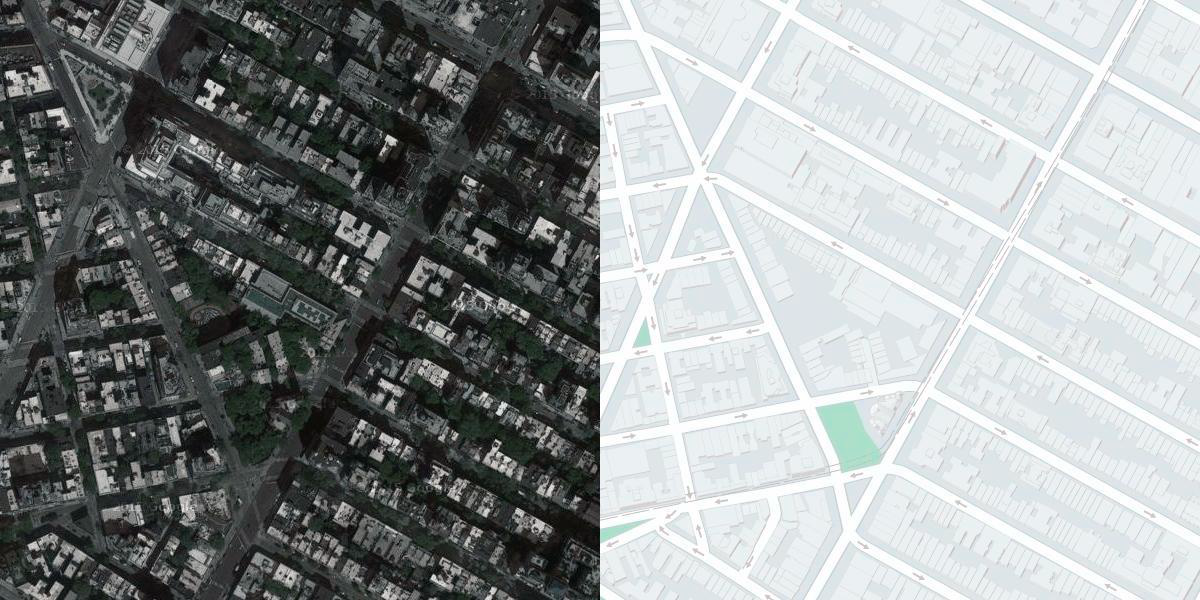

In [ ]:
temp = load_img("./maps/train/" + os.listdir("./maps/train/")[0])
temp = img_to_array(temp)
cv2_imshow(temp)

In [ ]:
def load_images(path, size=(256, 512)):
    source_list, target_list = [], []

    for filename in os.listdir(path):
        img = load_img(path + filename, target_size=size)
        img = img_to_array(img)
        sat_img, gmap_img = img[:, :256], img[:, 256:]
        source_list.append(sat_img)
        target_list.append(gmap_img)
    return [np.asarray(source_list), np.asarray(target_list)]

In [ ]:
path = "maps/train/"
[source_images, target_images] = load_images(path)
print("Loaded: ", source_images.shape, target_images.shape)

filename = "maps_256.npz"
np.savez_compressed(filename, source_images, target_images)
print("Saved Dataset : ", filename)

In [ ]:
data = np.load("./drive/MyDrive/SatMap-GMap Dataset/maps_256.npz")
source_images, target_images = data["arr_0"], data["arr_1"]
print("Loaded: ", source_images.shape, target_images.shape)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


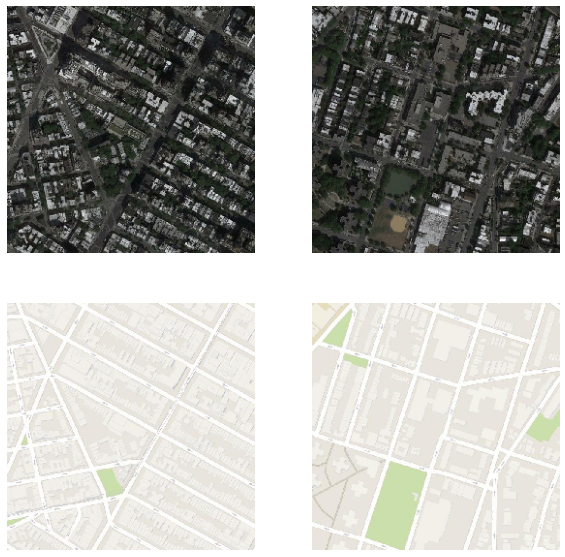

In [ ]:
n_samples = 2
plt.figure(figsize=(10, 10))
for i in range(n_samples):
    plt.subplot(2, n_samples, i + 1)
    plt.axis("off")
    plt.imshow(source_images[i].astype("uint8"))

for i in range(n_samples):
    plt.subplot(2, n_samples, i + n_samples + 1)
    plt.axis("off")
    plt.imshow(target_images[i].astype("uint8"))

plt.show()

In [ ]:
def create_discriminator(img_shape):
    init = RandomNormal(stddev = 0.02)
    in_source_image = Input(shape = img_shape)
    in_target_image = Input(shape = img_shape)
    merged_input = Concatenate()([in_source_image, in_target_image])

    x = Conv2D(64, (4, 4), strides=(2,2), padding="same", kernel_initializer=init)(merged_input)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), padding="same", kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1, (4, 4), padding="same", kernel_initializer=init)(x)
    patch_out = Activation("sigmoid")(x)

    model = keras.Model([in_source_image, in_target_image], patch_out)

    optimizer = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  loss_weights=[0.5])
    
    return model

In [ ]:
def encoder_block(input, kernel, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    x = Conv2D(kernel, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init)(input)
    if batchnorm:
        x = BatchNormalization()(x, training=True)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def decoder_block(input, skip_con, kernel, dropout=True):
    init = RandomNormal(stddev=0.02)
    x = Conv2DTranspose(kernel, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init)(input)
    x = BatchNormalization()(x, training=True)
    if dropout:
        x = Dropout(0.5)(x, training=True)
    x = Concatenate()([x, skip_con])
    x = Activation("relu")(x)
    return x

In [ ]:
def create_generator(image_shape=(256, 256, 3)):
    init = RandomNormal(stddev=0.02)
    input_image = Input(shape=image_shape)

    # Encoder of the U-Net Architecture
    enc_1 = encoder_block(input_image, 64, batchnorm=False)
    enc_2 = encoder_block(enc_1, 128)
    enc_3 = encoder_block(enc_2, 256)
    enc_4 = encoder_block(enc_3, 512)
    enc_5 = encoder_block(enc_4, 512)
    enc_6 = encoder_block(enc_5, 512)
    enc_7 = encoder_block(enc_6, 512)

    # BottleNeck of the U-Net Architecture
    latent_space = Conv2D(512, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init)(enc_7)
    latent_space = Activation("relu")(latent_space)

    # Decoder of the U-Net Architecture
    denc_1 = decoder_block(latent_space, enc_7, 512)
    denc_2 = decoder_block(denc_1, enc_6, 512)
    denc_3 = decoder_block(denc_2, enc_5, 512)
    denc_4 = decoder_block(denc_3, enc_4, 512, dropout = False)
    denc_5 = decoder_block(denc_4, enc_3, 256, dropout = False)
    denc_6 = decoder_block(denc_5, enc_2, 128, dropout = False)
    denc_7 = decoder_block(denc_6, enc_1, 64, dropout = False)

    x = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init)(denc_7)
    output = Activation("tanh")(x)

    model = keras.Model(input_image, output)
    return model

In [ ]:
def Pix2PixGAN(generator, discriminator, img_shape):
    for layer in discriminator.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    input_source = Input(shape=img_shape)
    gen_output = generator(input_source)
    disc_output = discriminator([input_source, gen_output])

    model = keras.Model(input_source, [disc_output, gen_output])
    optimizer = Adam(lr = 0.0002, beta_1 = 0.5)
    model.compile(loss=["binary_crossentropy", "mae"],
                    optimizer=optimizer,
                    loss_weights = [1, 100])
    return model

In [ ]:
def load_real_samples(filename):
    data = np.load(filename)
    X1, X2 = data["arr_0"], data["arr_1"]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
    trainA, trainB = dataset

    ix = np.random.randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[ix], trainB[ix]

    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [ ]:
def generate_fake_samples(generator, samples, patch_shape):
    X = generator.predict(samples)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [ ]:
def summarize_performance(step, generator, discriminator, dataset, n_samples = 3):
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    X_fakeB, _ = generate_fake_samples(generator, X_realA, 1)

    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis("off")
        plt.imshow(X_realA[i])

    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis("off")
        plt.imshow(X_fakeB[i])

    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples * 2 + i)
        plt.axis("off")
        plt.imshow(X_realB[i])
    
    fname1 = "plot%06d.png" % (step)
    plt.savefig(fname1)

    fname2 = "gen_%06d.h5" % (step)
    generator.save(fname2)

    fname3 = "disc_%06d.h5" % (step)
    discriminator.save(fname3)

    print(">Saved : %s and %s" % (fname1, fname2))

In [ ]:
def train(discriminator, generator, GAN, dataset, n_epochs = 50, n_batch = 1):
    n_patch = discriminator.output_shape[1]
    trainA, trainB = dataset

    batch_per_epoch = int(len(trainA) / n_batch)
    n_steps = batch_per_epoch * n_epochs

    for i in range(n_steps):
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        X_fakeB, y_fake = generate_fake_samples(generator, X_realA, n_patch)

        disc_loss1 = discriminator.train_on_batch([X_realA, X_realB], y_real)
        disc_loss2 = discriminator.train_on_batch([X_realA, X_fakeB], y_fake)

        gen_loss, _, _ = GAN.train_on_batch(X_realA, [y_real, X_realB])
        print(">%d,\tdiscriminator_loss1[%.3f] \tdiscriminator_loss2[%.3f] \tgenerator_loss[%.3f]" % (i + 1, disc_loss1, disc_loss2, gen_loss))
        if (i % 1096) == 0:
            print(">SAVING MODEL AND ITS GENERATED MAP IMAGES NOW...")
            summarize_performance(i / batch_per_epoch, generator, discriminator, dataset)

In [ ]:
dataset = load_real_samples("./drive/MyDrive/SatMap-GMap Dataset/maps_256.npz")
print("Loaded", dataset[0].shape, dataset[1].shape)
image_shape = dataset[0].shape[1:]

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


In [ ]:
# discriminator = create_discriminator(image_shape)
discriminator = keras.models.load_model("./drive/MyDrive/SatMap-GMap Dataset/Pix2Pix_GAN_trained/disc_109600.h5")
discriminator.compile(loss="binary_crossentropy",
                  optimizer=Adam(lr=0.0002, beta_1=0.5),
                  loss_weights=[0.5])
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 6208        concatenate[0][0]            

In [ ]:
# generator = create_generator(image_shape)
generator = keras.models.load_model("./drive/MyDrive/SatMap-GMap Dataset/Pix2Pix_GAN_trained/gen_109600.h5")
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 128, 64) 3136        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_5[0][0]              
____________________________________________________________________________________________

In [ ]:
gan_model = Pix2PixGAN(generator, discriminator, image_shape)
gan_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 256, 256, 3)  54429315    input_1[0][0]                    
__________________________________________________________________________________________________
model (Functional)              (None, 16, 16, 1)    6968257     input_1[0][0]                    
                                                                 model_1[0][0]                    
Total params: 61,397,572
Trainable params: 54,422,275
Non-trainable params: 6,975,297
__________________________________________________________________________________________________


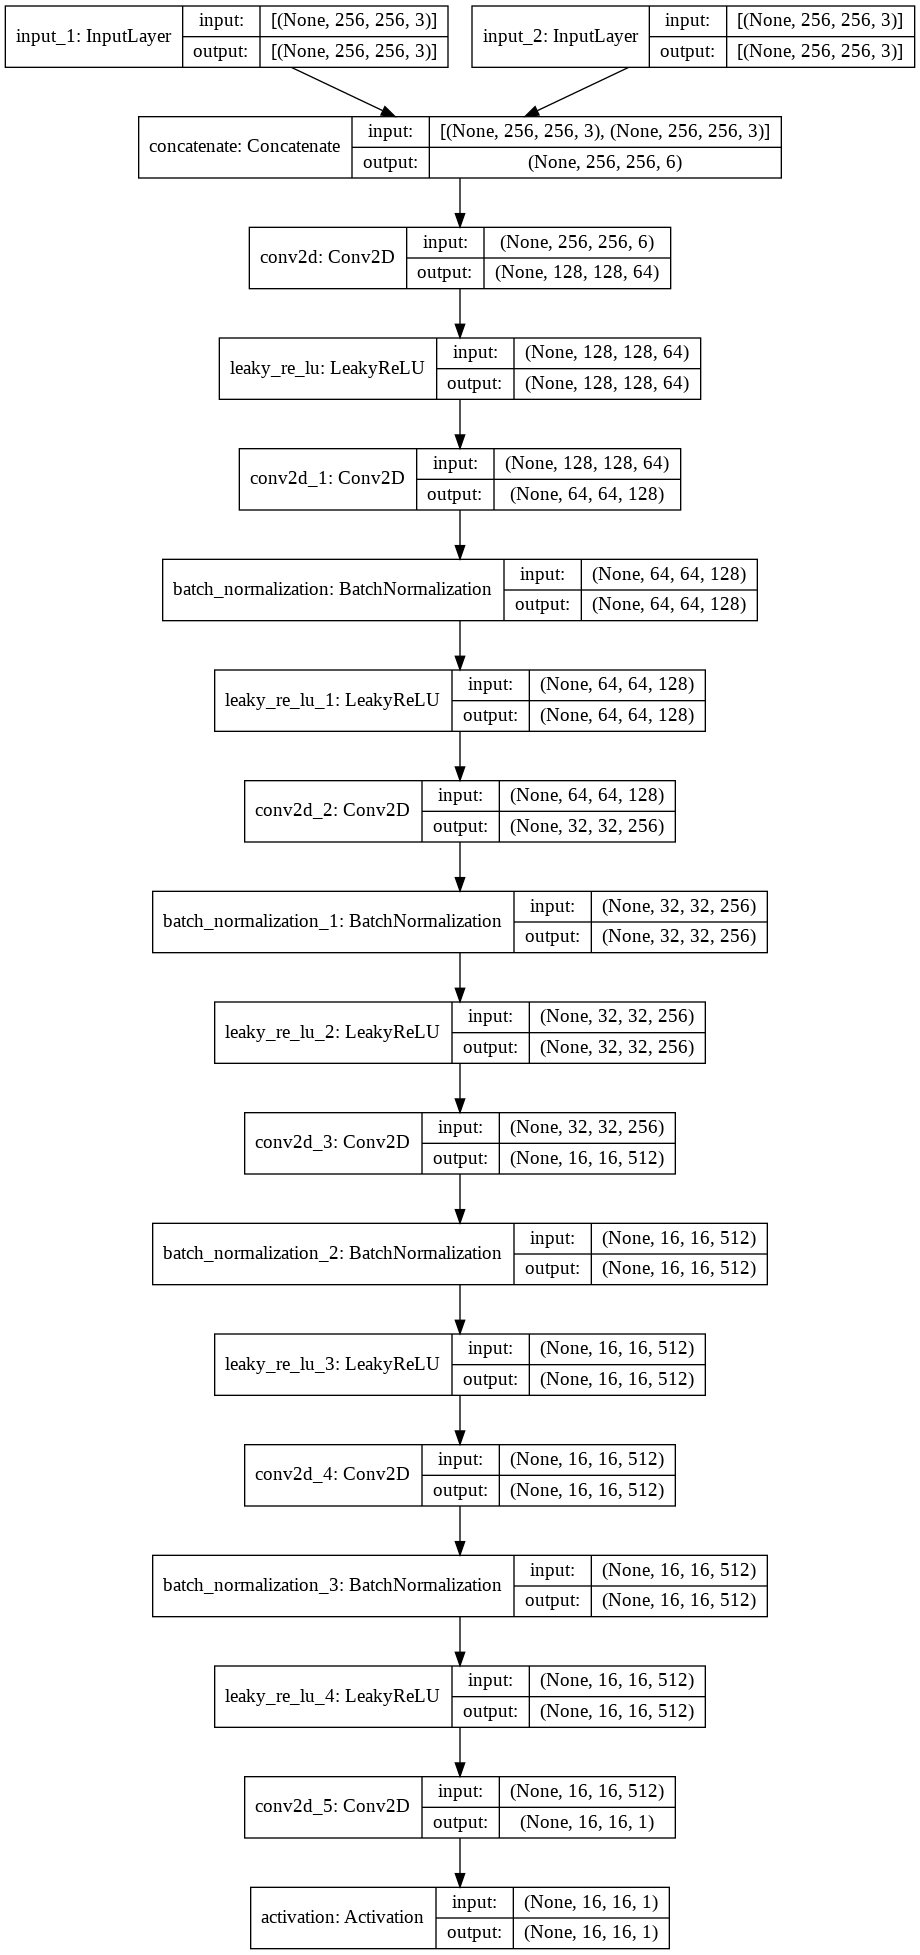

In [ ]:
plot_model(discriminator, to_file='discriminator_architecture.png', show_shapes=True, show_layer_names=True)

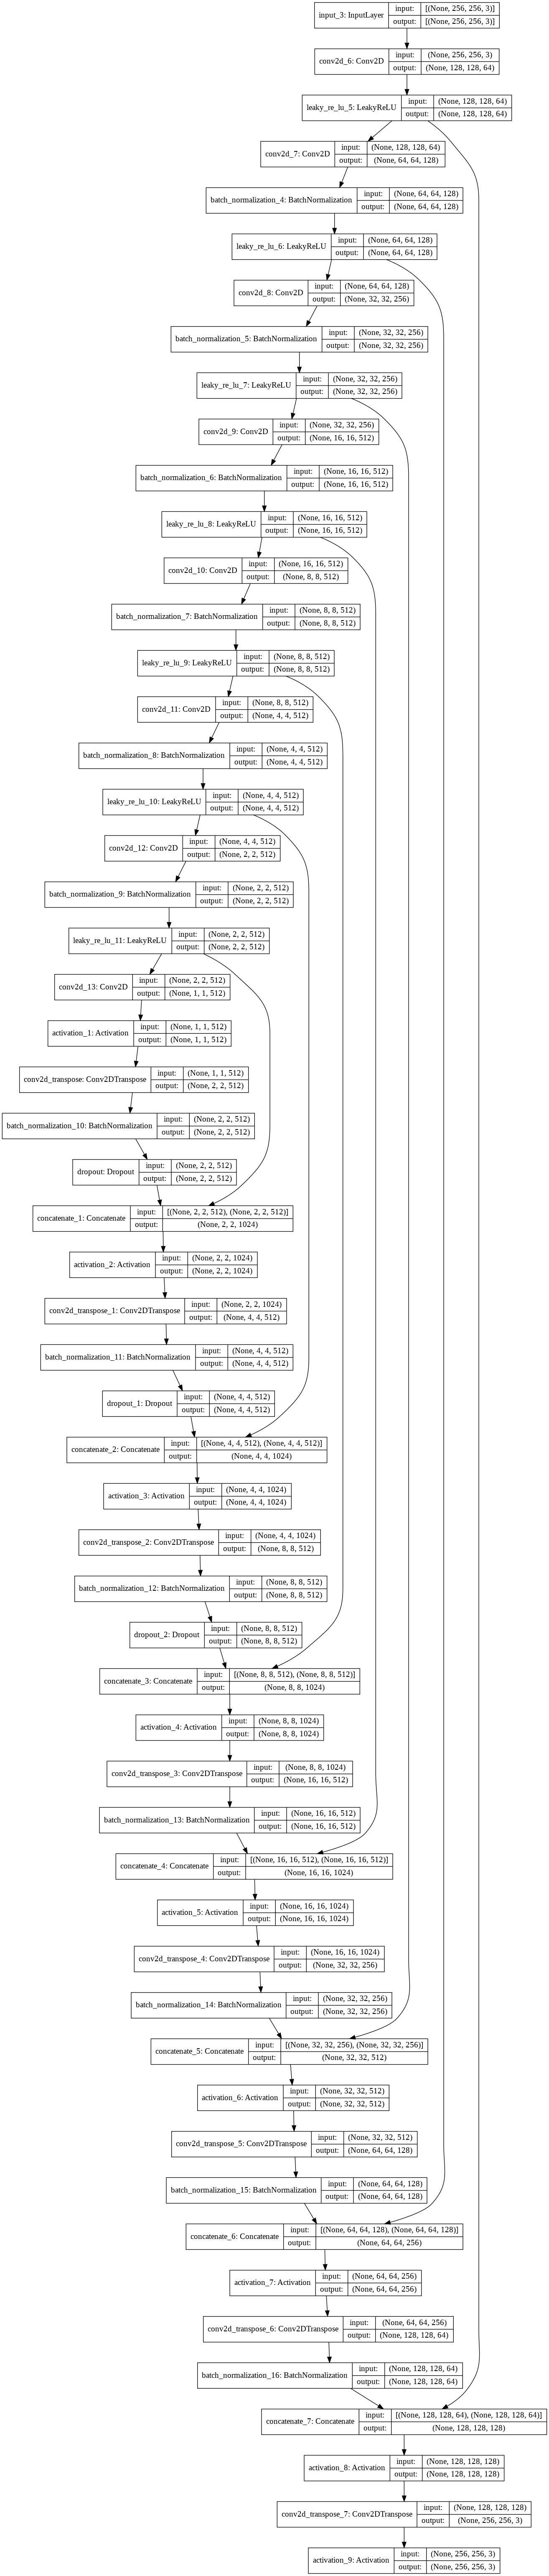

In [ ]:
plot_model(generator, to_file='generator_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# ------ delete unnecessary file other than Google Drive
# import os
# for file in os.listdir("./"):
#     if file != "drive":
#         try:
#             os.remove(file)
#         except:
#             pass

Streaming output truncated to the last 5000 lines.
>22118,	discriminator_loss1[0.118] 	discriminator_loss2[0.627] 	generator_loss[3.550]
>22119,	discriminator_loss1[0.137] 	discriminator_loss2[0.747] 	generator_loss[1.351]
>22120,	discriminator_loss1[0.151] 	discriminator_loss2[0.636] 	generator_loss[2.685]
>22121,	discriminator_loss1[0.124] 	discriminator_loss2[0.750] 	generator_loss[1.314]
>22122,	discriminator_loss1[0.175] 	discriminator_loss2[0.610] 	generator_loss[2.706]
>22123,	discriminator_loss1[0.121] 	discriminator_loss2[0.690] 	generator_loss[3.004]
>22124,	discriminator_loss1[0.102] 	discriminator_loss2[0.771] 	generator_loss[3.644]
>22125,	discriminator_loss1[0.140] 	discriminator_loss2[0.636] 	generator_loss[2.641]
>22126,	discriminator_loss1[0.118] 	discriminator_loss2[0.697] 	generator_loss[2.829]
>22127,	discriminator_loss1[0.128] 	discriminator_loss2[0.701] 	generator_loss[2.400]
>22128,	discriminator_loss1[0.136] 	discriminator_loss2[0.610] 	generator_loss[2.645]
>22

KeyboardInterrupt: ignored

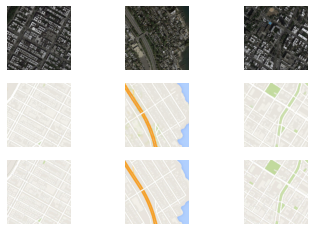

In [ ]:
train(discriminator, generator, gan_model, dataset)

In [ ]:
for file in os.listdir("./")[1:]:
    try:
        shutil.move("./" + file, "./drive/MyDrive/SatMap-GMap Dataset/Pix2Pix_GAN_trained/")
    except:
        pass

In [ ]:
# Generating Maps from Validation Set
[X1, X2] = load_real_samples("./drive/MyDrive/SatMap-GMap Dataset/maps_256.npz")
print(f"Loaded : {X1.shape}, {X2.shape}")

Loaded : (1096, 256, 256, 3), (1096, 256, 256, 3)


In [ ]:
trained_generator = keras.models.load_model("./drive/MyDrive/SatMap-GMap Dataset/Pix2Pix_GAN_trained/gen_109600.h5")

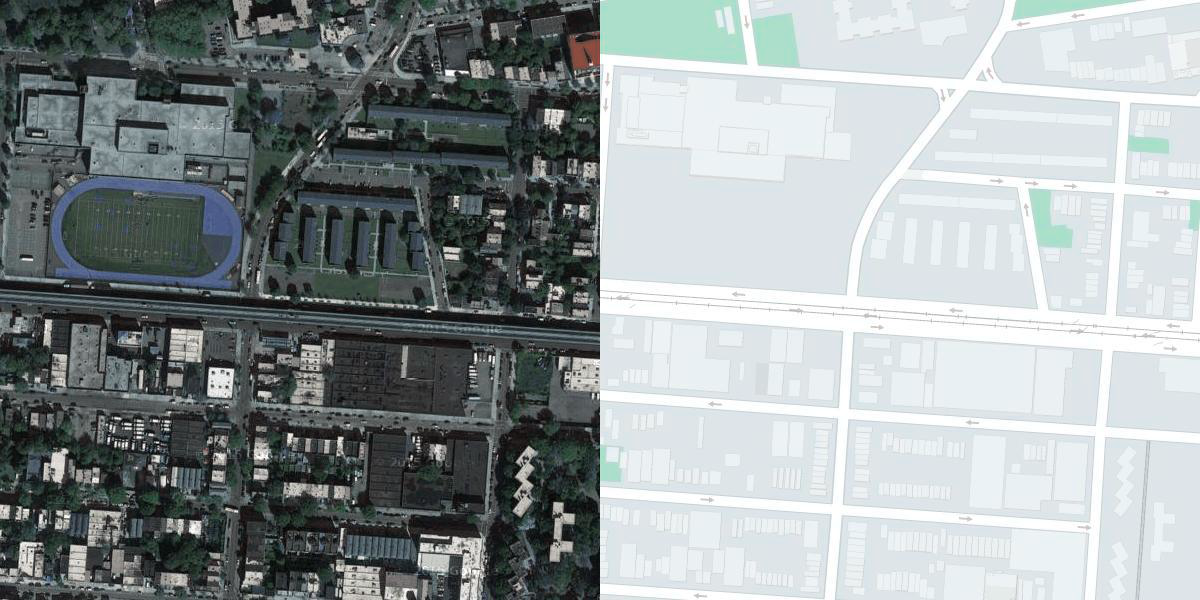

In [ ]:
temp = load_img("./maps/val/" + os.listdir("./maps/val/")[0])
temp = img_to_array(temp)
cv2_imshow(temp)

In [ ]:
val_source_images, val_target_images = load_images("./maps/val/")
val_source_images = (val_source_images - 127.5) / 127.5
val_target_images = (val_target_images - 127.5) / 127.5
val_source_images.shape, val_target_images.shape

((1098, 256, 256, 3), (1098, 256, 256, 3))

In [ ]:
ix = np.random.randint(0, len(val_source_images), 1)
val_src_img, val_trg_img = val_source_images[ix], val_target_images[ix]

In [ ]:
def plot_images(src_img, gen_img, tar_img):
	images = np.vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	for i in range(len(images)):
		plt.subplot(1, 3, 1 + i)
		plt.axis('off')
		plt.imshow(images[i])
		plt.title(titles[i])
	plt.show()

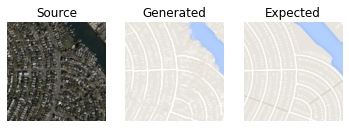

In [ ]:
generated_image = generator.predict(val_src_img)
plot_images(val_src_img, generated_image, val_trg_img)

In [ ]:
anim_file = "pix2pix_gan.gif"

with imageio.get_writer(anim_file, mode="I") as writer:
    filenames = glob.glob('./drive/MyDrive/SatMap-GMap Dataset/Pix2Pix_GAN_trained/*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

embed.embed_file(anim_file)

Output hidden; open in https://colab.research.google.com to view.